In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time
from data import radio_data, radio_qs_epochs
from flux_utils import flux_conversion
from plots import fontsize, fig_width

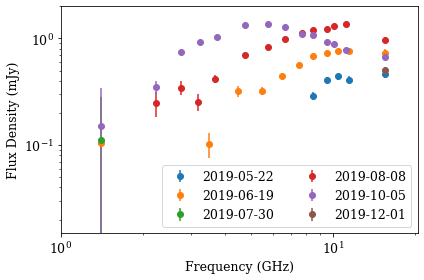

In [9]:
plt.figure(figsize=(fig_width, fig_width * 2./3.))
ax = plt.subplot(111)

for i, date_mjd in enumerate(sorted(list(set(radio_qs_epochs)))):
    data = radio_data[radio_qs_epochs == date_mjd]
    date = Time(date_mjd, format="mjd")
    date.format = "iso"
    date.out_subfmt = 'date'
    plt.errorbar(data["frequency"], data["flux"], yerr=data["flux_err"], marker="o", fmt=" ", label=date)

    
#     plt.errorbar(data["frequency"], data["flux"], yerr=data["flux_err"], marker="o", fmt=" ", label=date)
    
plt.xlim(1.0, 20.5)
plt.ylim(0.015, 2.)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (GHz)", fontsize=fontsize)
plt.ylabel("Flux Density (mJy)", fontsize=fontsize)
plt.legend(fontsize=fontsize, ncol=2, loc="lower right")
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.tight_layout()
plt.savefig("plots/radio_spectrum.pdf")